<a href="https://colab.research.google.com/github/Nanashi-bot/GANs/blob/main/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch import optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [19]:
# Defining transform

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [20]:
# Importing CIFAR-10

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [41]:
x = next(iter(train_dataloader))

In [48]:
x[0].shape

torch.Size([32, 3, 32, 32])

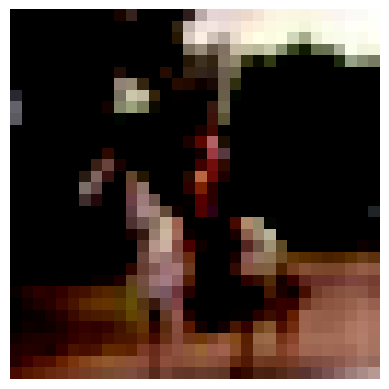

<Figure size 500x300 with 0 Axes>

In [55]:
plt.imshow(x[0][0].permute(1, 2, 0))
plt.axis('off')
plt.figure(figsize=(5,3))
plt.show()

In [36]:
# Hyperparameters

latent_dim = 100
lr = 0.0001
beta1 = 0.5
beta2 = 0.999
num_epochs = 10

In [77]:
# Create generator:

class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 256 * 8 * 8),
            nn.ReLU(),
            nn.Unflatten(1, (256, 8, 8)),
            # nn.Upsample(scale_factor = 2),
            nn.ConvTranspose2d(256, 128, kernel_size=5, stride=1, padding=2), # For padding = same we use padding = stride // 2
            nn.BatchNorm2d(128, momentum = 0.78),
            nn.ReLU(),
            # nn.Upsample(scale_factor = 2),
            nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.BatchNorm2d(64, momentum=0.78),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.Tanh()
            )
    def forward(self, x):
        img = self.model(x)
        return img

In [69]:
# Create discriminator

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(0.2),
            # nn.Dropout(0.25),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(0.2),
            # nn.ZeroPad2d((0, 1, 0, 1)),
            nn.BatchNorm2d(128, momentum=0.82),
            # nn.LeakyReLU(0.25),
            # nn.Dropout(0.25),
            # nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            # nn.BatchNorm2d(128, momentum=0.82),
            # nn.LeakyReLU(0.2),
            # nn.Dropout(0.25),
            # nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            # nn.BatchNorm2d(256, momentum=0.8),
            # nn.LeakyReLU(0.25),
            # nn.Dropout(0.25),
            nn.Flatten(),
            nn.Linear(128 * 8 * 8, 1),
            nn.Sigmoid()
            )
    def forward(self, img):
        validity = self.model(img)
        return validity

In [78]:
generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)
# Loss function
adversarial_loss = nn.BCELoss()
# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, beta2))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, beta2))

In [79]:
# Testing discriminator
test_input_img = torch.rand(32, 3, 32, 32).to(device)
output = discriminator(test_input_img)
print(output.shape)

torch.Size([32, 1])


In [80]:
# Testing generator
test_input_noise = torch.rand(32, latent_dim).to(device)
output = generator(test_input_noise)
print(output.shape)

torch.Size([32, 3, 32, 32])


In [81]:
def discriminator_loss(real_output, fake_output):
    real_loss = adversarial_loss(real_output, torch.ones_like(real_output))
    fake_loss = adversarial_loss(fake_output, torch.zeros_like(fake_output))
    total_loss = real_loss + fake_loss
    return total_loss

In [82]:
def generator_loss(fake_output):
    return adversarial_loss(fake_output, torch.ones_like(fake_output))

In [134]:
def train_step(real_images_batch):
    batch_size = 32
    noise_dim = 100
    real_images_batch = next(iter(train_dataloader))
    noise = torch.randn(batch_size, noise_dim)

    # # Training discriminator
    optimizer_D.zero_grad()
    fake_images = generator(noise)
    real_output = discriminator(real_images_batch[0])
    fake_output = discriminator(fake_images.detach())
    disc_loss = discriminator_loss(real_output, fake_output)
    disc_loss.backward()
    optimizer_D.step()

    # Training generator
    optimizer_G.zero_grad()
    generated_images = generator(noise)
    fake_output = discriminator(generated_images)
    gen_loss = generator_loss(fake_output)
    gen_loss.backward()
    optimizer_G.step()
    print(f"Generator loss: {gen_loss.item()}, Discriminator loss: {disc_loss.item()}")
    return gen_loss.item(), disc_loss.item()

In [135]:
def train(train_dataloader, num_epochs):
    for epoch in range(num_epochs):
        for image_batch in train_dataloader:
            train_step(image_batch)

In [136]:
train(train_dataloader,2)
# Takes 32 minutes without gpu

Generator loss: 0.5990892052650452, Discriminator loss: 2.0022706985473633
Generator loss: 0.5379568338394165, Discriminator loss: 2.0946738719940186
Generator loss: 0.5476500391960144, Discriminator loss: 2.1872787475585938
Generator loss: 0.46638616919517517, Discriminator loss: 2.4412481784820557
Generator loss: 0.50625079870224, Discriminator loss: 2.332075357437134
Generator loss: 0.5981793999671936, Discriminator loss: 2.232046127319336
Generator loss: 0.7152092456817627, Discriminator loss: 1.940292477607727
Generator loss: 0.6282390356063843, Discriminator loss: 2.2394113540649414
Generator loss: 0.697138786315918, Discriminator loss: 2.1170458793640137
Generator loss: 0.7235879302024841, Discriminator loss: 2.114246368408203
Generator loss: 0.7256515026092529, Discriminator loss: 1.9981653690338135
Generator loss: 0.7262833118438721, Discriminator loss: 2.0956661701202393
Generator loss: 0.7398228645324707, Discriminator loss: 2.003434896469116
Generator loss: 0.81940931081771

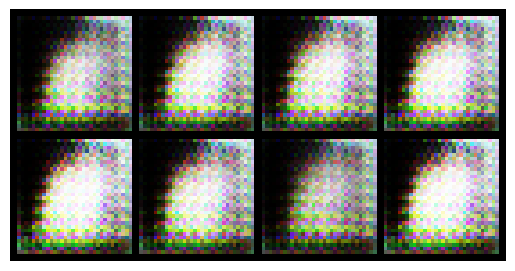

In [140]:
import torchvision
generator.eval()
with torch.no_grad():
    z = torch.randn(8, latent_dim, device=device)
    generated = generator(z).detach().cpu()
    grid = torchvision.utils.make_grid(generated, nrow=4, normalize=True)
    plt.imshow(np.transpose(grid, (1, 2, 0)))
    plt.axis("off")
    plt.show()

In [93]:
# Testing
# 1563 batches exist
# for image_batch in train_dataloader:
#     # train_step(image_batch)
#     print(image_batch[0].shape)

torch.Size([32, 3, 32, 32])
torch.Size([32, 3, 32, 32])
torch.Size([32, 3, 32, 32])
torch.Size([32, 3, 32, 32])
torch.Size([32, 3, 32, 32])
torch.Size([32, 3, 32, 32])
torch.Size([32, 3, 32, 32])
torch.Size([32, 3, 32, 32])
torch.Size([32, 3, 32, 32])
torch.Size([32, 3, 32, 32])
torch.Size([32, 3, 32, 32])
torch.Size([32, 3, 32, 32])
torch.Size([32, 3, 32, 32])
torch.Size([32, 3, 32, 32])
torch.Size([32, 3, 32, 32])
torch.Size([32, 3, 32, 32])
torch.Size([32, 3, 32, 32])
torch.Size([32, 3, 32, 32])
torch.Size([32, 3, 32, 32])
torch.Size([32, 3, 32, 32])
torch.Size([32, 3, 32, 32])
torch.Size([32, 3, 32, 32])
torch.Size([32, 3, 32, 32])
torch.Size([32, 3, 32, 32])
torch.Size([32, 3, 32, 32])
torch.Size([32, 3, 32, 32])
torch.Size([32, 3, 32, 32])
torch.Size([32, 3, 32, 32])
torch.Size([32, 3, 32, 32])
torch.Size([32, 3, 32, 32])
torch.Size([32, 3, 32, 32])
torch.Size([32, 3, 32, 32])
torch.Size([32, 3, 32, 32])
torch.Size([32, 3, 32, 32])
torch.Size([32, 3, 32, 32])
torch.Size([32, 3, 3

In [35]:
torch.save(generator.state_dict(), 'generator.pth')
torch.save(discriminator.state_dict(), 'discriminator.pth')

In [130]:
# # For one pass:
# noise_dim = 100
# real_images_batch = next(iter(train_dataloader))
# noise = torch.randn(32, noise_dim)

# # Training discriminator
# optimizer_D.zero_grad()
# fake_images = generator(noise)
# real_output = discriminator(real_images_batch[0])
# fake_output = discriminator(fake_images.detach())
# disc_loss = discriminator_loss(real_output, fake_output)
# disc_loss.backward()
# optimizer_D.step()

# # Training generator
# optimizer_G.zero_grad()
# generated_images = generator(noise)
# fake_output = discriminator(generated_images)
# gen_loss = generator_loss(fake_output)
# gen_loss.backward()
# optimizer_G.step()